### Efficiency of pytraj/cpptraj in doing multiple actions/analyses

In [1]:
from __future__ import print_function # for python2 and 3 compat
import pytraj.io as mdio # control all the IO of pytraj.
from pytraj.ActionList import ActionList # ActionList class is not automcally loaded to pytraj's namespace (yet)
from pytraj import adict # load action's dict. `adict['distance']. Try "print (adict.keys())

help(ActionList.add_action)

Help on method_descriptor:

add_action(...)
    ActionList.add_action(self, action='', command='', top=None, DataSetList dslist=<???>, DataFileList dflist=<???>, check_status=False)
    
    Add action to ActionList
    
    Parameters:
    action : str or Action object
    command : str or ArgList object
    top : str | Topology | TopologyList
    dslist : DataSetList 
    dflist : DataFileList
    check_status : bool, default=False
        return status of Action (0 or 1) if "True"



In [2]:
# load traj
traj = mdio.load("../tests/data/md1_prod.Tc5b.x", "../tests/data/Tc5b.top")

print (traj)

# create DataSetList to hold data and DataFileList to write data to disk
from pytraj import DataSetList, DataFileList
dslist = DataSetList()
dflist = DataFileList()

# creat ActionList to hold actions
alist = ActionList()

# add two actions: Action_Dihedral and Action_Distance
alist.add_action(adict['distance'], ":2@CA :10@CA out ./output/_dist.out",
                 traj.top, dslist, dflist)
alist.add_action(adict['dihedral'], ":2@CA :3@CA :4@CA :5@CA out ./output/_dih.out",
                 traj.top, dslist, dflist)

# using string for action 'dssp' (you can use either string or Action object)
alist.add_action('dssp', "out ./output/_dssp_alist.out",
                 traj.top, dslist=dslist, dflist=dflist)
alist.add_action('matrix', "@CA out ./output/_mat_alist.out",
                 traj.top, dslist, dflist)

# try to save traj to CHARMM DCD too
alist.add_action("outtraj", "./output/test_trajout.dcd", traj.top)

# let's creat a list of Frame, traj (pytraj can handle those too)
# crazy_traj_list if a Python list of [Frame, Frame, TrajReadOnly, chunk_iter for traj, frame_iter for traj]
crazy_traj_list = [traj[0], traj[1], traj,
                  traj.chunk_iter(chunk=4, stop=8) , traj.frame_iter()]

alist.do_actions(crazy_traj_list) # this workd too: alist.do_actions(traj)

<TrajReadOnly with 10 frames, 304 atoms/frame>
           


In [3]:
# let's look at the result
print ('dslist.size', dslist.size)
print("")
print ('dslist.get_lengends', dslist.get_legends())

dslist.size 31

dslist.get_lengends [u'Dis_00000', u'Dih_00001', u'DSSP_00002[None]', u'DSSP_00002[Para]', u'DSSP_00002[Anti]', u'DSSP_00002[3-10]', u'DSSP_00002[Alpha]', u'DSSP_00002[Pi]', u'DSSP_00002[Turn]', u'DSSP_00002[Bend]', u'Mat_00010', u'ASN:1', u'LEU:2', u'TYR:3', u'ILE:4', u'GLN:5', u'TRP:6', u'LEU:7', u'LYS:8', u'ASP:9', u'GLY:10', u'GLY:11', u'PRO:12', u'SER:13', u'SER:14', u'GLY:15', u'ARG:16', u'PRO:17', u'PRO:18', u'PRO:19', u'SER:20']


In [4]:
# want to get dihedral as specified previously?
print (dslist.groupby("Dih").to_ndarray())

[ 158.66493195   57.60817098  158.66493195   57.60817098   99.18171694
   74.54385107 -173.21259579 -171.74661774 -115.50913622 -154.70275411
 -107.73215035  103.53386267  158.66493195   57.60817098   99.18171694
   74.54385107 -173.21259579 -171.74661774 -115.50913622 -154.70275411
 -107.73215035  158.66493195   57.60817098   99.18171694   74.54385107
 -173.21259579 -171.74661774 -115.50913622 -154.70275411 -107.73215035
  103.53386267]


<pytraj.datasets.DataSet_MatrixDbl.DataSet_MatrixDbl object at 0x2aaacb445fc0> matrix_dbl


(<matplotlib.figure.Figure at 0x2aaac89515d0>,
 <matplotlib.image.AxesImage at 0x2aaacb79cad0>)

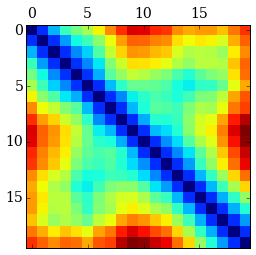

In [5]:
# want to get the matrix result and plot?
# to show plot in ipython-notebook use "%matplotlib inline"
%matplotlib inline 

mat = dslist.groupby("Mat_")[0] #
print (mat, mat.dtype)

from pytraj.plots import plot_matrix # require matplotlib
plot_matrix(mat)

In [6]:
# Did we save CHARMM DCD file yet? YES
!ls ./output/test_trajout.dcd

./output/test_trajout.dcd


### Comparing speed

In [7]:
import pytraj.common_actions as pyca

def use_actionlist(crazy_traj_list):
    from pytraj import DataSetList, DataFileList
    dslist = DataSetList()
    dflist = DataFileList()

    # creat ActionList to hold actions
    alist = ActionList()

    # add two actions: Action_Dihedral and Action_Distance
    alist.add_action(adict['distance'], ":2@CA :10@CA out ./output/_dist.out",
                     traj.top, dslist, dflist)
    alist.add_action(adict['dihedral'], ":2@CA :3@CA :4@CA :5@CA out ./output/_dih.out",
                     traj.top, dslist, dflist)
    # using string for action 'dssp' (you can use either string or Action object)
    alist.add_action('dssp', "out ./output/_dssp_alist.out",
                     traj.top, dslist=dslist, dflist=dflist)
    alist.add_action('matrix', "@CA out ./output/_mat_alist.out",
                     traj.top, dslist, dflist)
    alist.do_actions(crazy_traj_list) # this workd too: alist.do_actions(traj) 
    
def use_tradional_calc(crazy_traj_list):
    pyca.calc_distance(crazy_traj_list, ":2@CA :10@CA out ./output/_dist.out", top=traj.top)
    pyca.calc_dihedral(crazy_traj_list, ":2@CA :3@CA :4@CA :5@CA out ./output/_dih.out", top=traj.top)
    pyca.calc_dssp(crazy_traj_list, "out ./output/_dssp_alist.out", dtype='dataset', top=traj.top)
    pyca.calc_matrix(crazy_traj_list, "@CA out ./output/_mat_alist.out", top=traj.top)

In [8]:
crazy_traj_list = [traj[0], traj[1], traj,
                  traj.chunk_iter(chunk=4, stop=8) , traj.frame_iter()]

%timeit use_actionlist(crazy_traj_list)
%timeit use_tradional_calc(crazy_traj_list)

100 loops, best of 3: 5.73 ms per loop
100 loops, best of 3: 32.5 ms per loop


In [9]:
# `use_actionlist` is much more efficient than `use_tradional_calc` (about 6 times) when we need to use 
# multiple actions for frame/traj.
# This is because we only need to iterate `crazy_traj_list` once in `use_actionlist` 
# while we need to iterate `crazy_traj_list` four times in `use_tradional_calc`